In [1]:
#Note, Cartopy is a python package which will install through Conda:
#using Conda; Conda.add("Cartopy")

using PyPlot, PyCall, CSV, DataFrames, Dates

#See example of Cartopy pie charts in Python here:
#https://stackoverflow.com/questions/45266955/adding-pie-chart-at-given-coordinates-to-cartopy-projection
#The following adapts these for use in Julia:
function plot_pie_inset(data,ilon,ilat,ax,width)
    ax_sub = inset_axes(ax, width=width, height=width, loc=10, 
                       bbox_to_anchor=(ilon, ilat),
                       bbox_transform=ax.transData, 
                       borderpad=0)
    wedges,texts= ax_sub.pie(data, colors = color_list, normalize=true)
    ax_sub.set_aspect("equal")
end

function add_pie(freqs,loc; siz = 0.3)
    lat,lon = loc
    lonr,latr =  ccrs.PlateCarree().transform_point(lon,lat, ccrs.PlateCarree())
    plot_pie_inset(freqs,lonr,latr,ax,siz)
end

inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
inset_axes = inset_locator.inset_axes

sum2one(v) = v/sum(v);

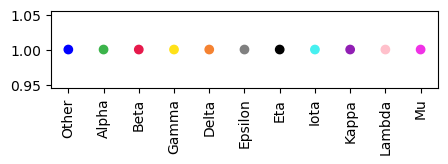

In [2]:
df = CSV.read("lat_and_lon.csv",DataFrame);
name_loc_dict = Dict(zip(df.Country, collect(zip(df.Latitude,df.Longitude))));
estimate_df = CSV.read("CountryEstimates.csv",DataFrame);

#Manually adjusting which get plotted, for aesthetic/overlap reasons, or unreliable estimates/data.
blacklist = ["Ghana", "Turkey","Nigeria", "Rwanda"]
whitelist = ["Uganda"]
bl = union(estimate_df.Country[(estimate_df.NeffBefore .< 10.0) .| (estimate_df.NeffAfter .< 5.0)])
blacklist = union(vcat(blacklist,bl));
blacklist = [b for b in blacklist if !(b in whitelist)]
clean_df = estimate_df[[!(c in blacklist) for c in estimate_df.Country],:];

#For easily figuring out which colors you want to plot each lineage as:
variant_labels = names(estimate_df)[5:end];
color_list = ["#f032e6", "pink",  "#911eb4", "#46f0f0", "#ffe119", "black","grey","#f58231","#e6194b","#3cb44b","blue"];
figure(figsize = (5,1))
leg_ordering = [11,10,9,5,8,7,6,4,3,2,1]
scatter(1:length(color_list),ones(length(color_list)),c = color_list[leg_ordering])
xticks(1:length(color_list),variant_labels[leg_ordering], rotation = 90);

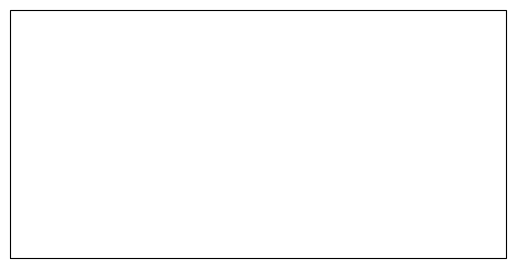

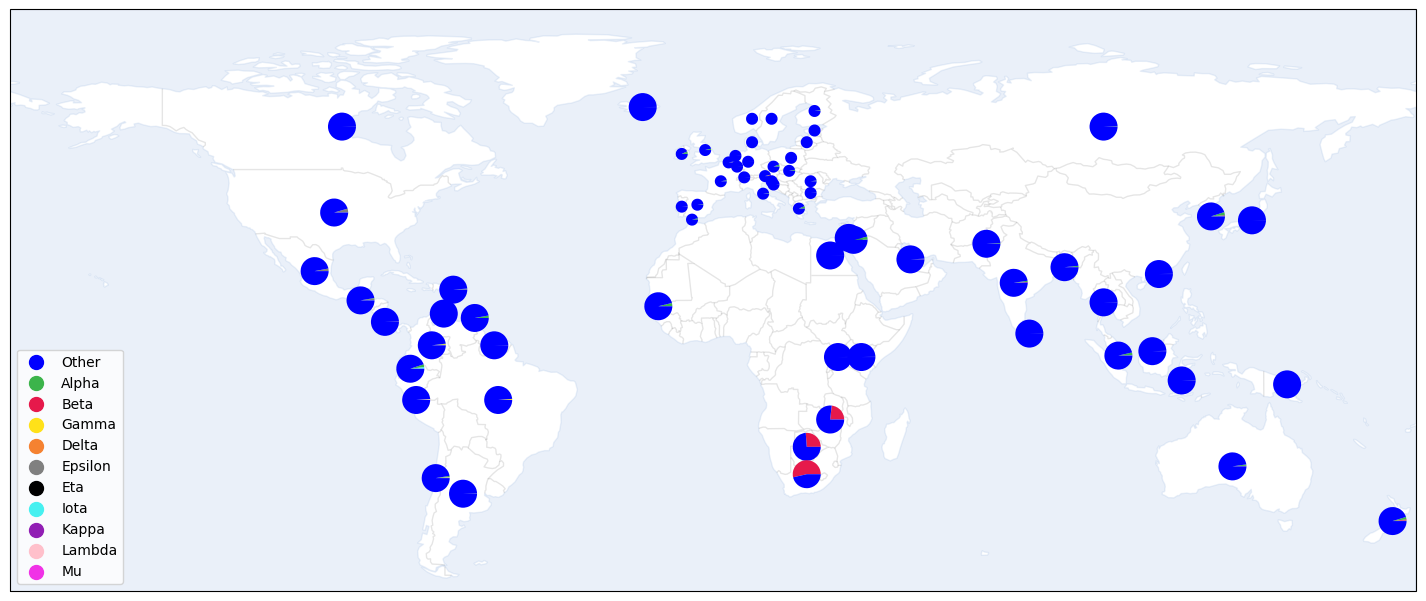

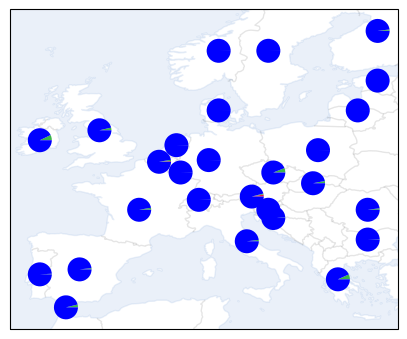

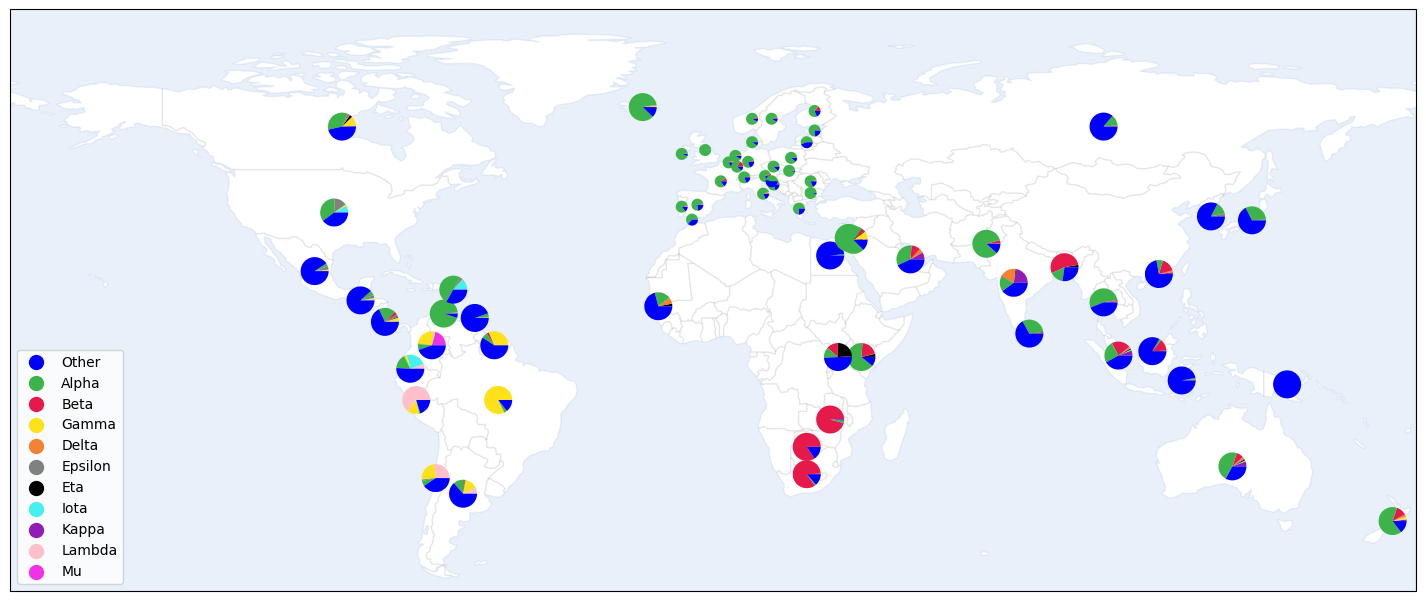

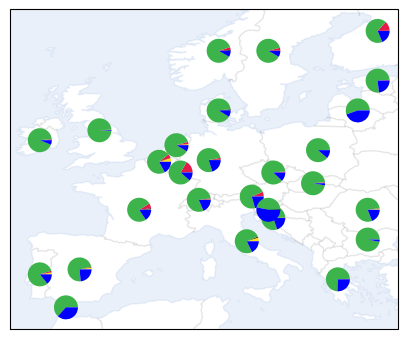

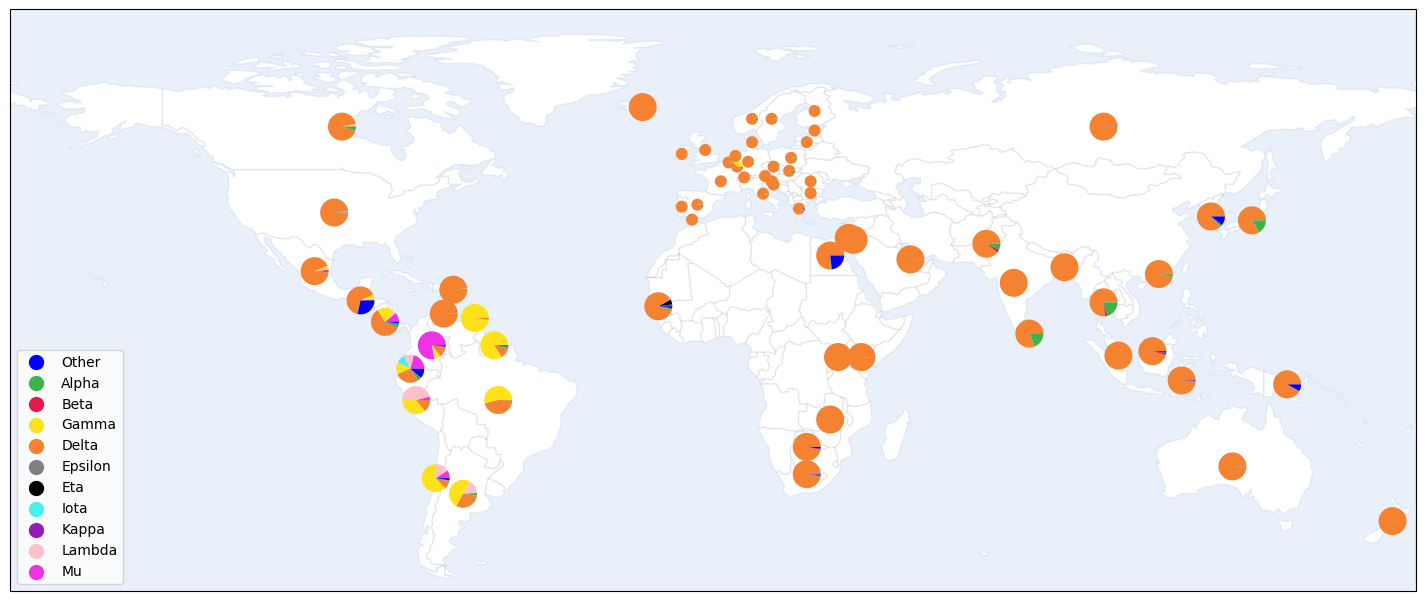

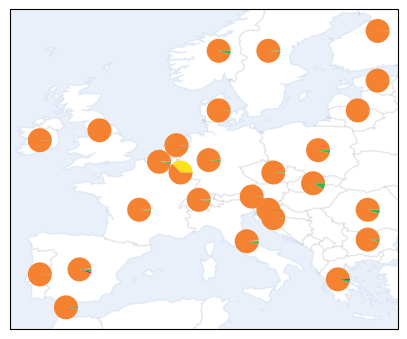

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [3]:
#Note: this makes strong assumptions about the structure of the exported estimates.
#Will probably only work on data exported by the other notebook in this repo.
ccrs = pyimport("cartopy.crs")
cfeat = pyimport("cartopy.feature")
#The loop below isn't happy unless this is global.
ax = subplot(projection=ccrs.PlateCarree());

for shf in 1:3 #Loop through each of the dates at which frequencies have been estimated.
    date = clean_df.Day[shf]

    freq_vecs = Array{Float64}[]
    locs = Tuple{Float64, Float64}[]
    for i in shf:3:size(clean_df)[1]
        push!(freq_vecs,Array{Float64}(clean_df[i,5:end]))
        push!(locs,name_loc_dict[clean_df.Country[i]])
    end

    #Plot the world
    fig = figure(figsize = (15,8))
    ax = subplot(projection=ccrs.PlateCarree())
    ax.add_feature(cfeat.OCEAN, alpha = 0.2)
    ax.add_feature(cfeat.BORDERS, linestyle="-", alpha=0.1)
    ax.set_extent([-60, 180, -40, 90])
    #Europe box
    lonl, lonh = -13, 40
    latl,lath = 32, 68
    for i in 1:length(locs)
        si = 0.35
        #Smaller sizes inside the Europe box
        if locs[i][1] > latl && locs[i][1] < lath && locs[i][2] > lonl && locs[i][2] < lonh
            si = 0.15
        end
        add_pie(sum2one(freq_vecs[i]),locs[i], siz = si)
    end
    for i in 1:length(color_list)
        ax.scatter([],[],s = 100.0, label = variant_labels[leg_ordering][i], color = color_list[leg_ordering][i])
    end
    ax.annotate(string(date),(0.865,0.84),xycoords = "figure fraction", size = "x-large")
    ax.legend(loc = "lower left")
    tight_layout()

    savefig("Maps/world$(date).svg")
    savefig("Maps/world$(date).pdf")
    
    #Now plot Europe
    fig = figure(figsize = (5,5))
    ax = subplot(projection=ccrs.PlateCarree())
    ax.add_feature(cfeat.OCEAN, alpha = 0.2)
    ax.add_feature(cfeat.BORDERS, linestyle="-", alpha=0.1)
    lonl, lonh = -11, 28
    latl,lath = 34, 65
    ax.set_extent([lonl, lonh, latl,lath])
    for i in 1:length(locs)
        if locs[i][1] > latl && locs[i][1] < lath && locs[i][2] > lonl && locs[i][2] < lonh
            add_pie(sum2one(freq_vecs[i]),locs[i],siz = 0.3)
        end
    end
    savefig("Maps/europe$(date).svg")
    savefig("Maps/europe$(date).pdf")
end